In [1170]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, recall_score, precision_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score

from imblearn.over_sampling import RandomOverSampler

In [1171]:
df = pd.read_csv(r'healthcare-dataset-stroke-data.csv')

In [1172]:
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


### Description

1) id: unique identifier  
2) gender: "Male", "Female" or "Other"  
3) age: age of the patient  
4) hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension  
5) heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease  
6) ever_married: "No" or "Yes"  
7) work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"  
8) Residence_type: "Rural" or "Urban"  
9) avg_glucose_level: average glucose level in blood  
10) bmi: body mass index  
11) smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"*  
12) stroke: 1 if the patient had a stroke or 0 if not  
*Note: "Unknown" in smoking_status means that the information is unavailable for this patient  

# Organization of data

### Missing values

In [1173]:
df.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

the missing BMI results will be filled with one's gender's BMI mean

In [1174]:
maleBMI = df[df['gender']=='Male']['bmi'].mean()
femaleBMI = df[df['gender']=='Female']['bmi'].mean()
otherBMI = df[df['gender']=='Other']['bmi'].mean()

df.loc[df.gender=='Male'] = df.loc[df.gender=='Male'].fillna(maleBMI)
df.loc[df.gender=='Female'] = df.loc[df.gender=='Female'].fillna(femaleBMI)
df.loc[df.gender=='Other'] = df.loc[df.gender=='Other'].fillna(otherBMI)

In [1175]:
df.isnull().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

### Mapping categorial data

There are some columns that contain categorial data. I'm going to find all kinds of categories in each column using groupby

In [1176]:
categorial = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'] # unique() can be used too
for i in categorial:
    g = df.groupby(i)
    print(i,':', g.groups.keys())

gender : dict_keys(['Female', 'Male', 'Other'])
ever_married : dict_keys(['No', 'Yes'])
work_type : dict_keys(['Govt_job', 'Never_worked', 'Private', 'Self-employed', 'children'])
Residence_type : dict_keys(['Rural', 'Urban'])
smoking_status : dict_keys(['Unknown', 'formerly smoked', 'never smoked', 'smokes'])


In [1177]:
df['gender'] = df['gender'].map({'Male':0, 'Female':1, 'Other':2})
df['ever_married'] = df['ever_married'].map({'No':0, 'Yes':1})
df['work_type'] = df['work_type'].map({'Govt_job':0, 'Never_worked':1, 'Private':2, 'Self-employed':3, 'children':4})
df['Residence_type'] = df['Residence_type'].map({'Rural':0, 'Urban':1})
df['smoking_status'] = df['smoking_status'].map({'Unknown':0, 'formerly smoked':1, 'never smoked':2, 'smokes':3})

In [1178]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,0,67.0,0,1,1,2,1,228.69,36.600000,1,1
1,51676,1,61.0,0,0,1,3,0,202.21,29.065758,2,1
2,31112,0,80.0,0,1,1,2,0,105.92,32.500000,2,1
3,60182,1,49.0,0,0,1,2,1,171.23,34.400000,3,1
4,1665,1,79.0,1,0,1,3,0,174.12,24.000000,2,1


# Analysis

Exploring the data will help us understand it and its conections better  
I will try to find a connection between each feature to 'stroke'  
Description with mapping info:
- 'gender' - 0 if Male, 1 if Female or 2 if Other
- 'age' - age of the patient
- 'hypertension' -  0 if the patient doesn't have hypertension, 1 if the patient has hypertension
- 'heart_disease' - 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
- 'ever_married' - 0 if "No", 1 if "Yes"
- 'work_type' - 0 if govt job, 1 if never_worked, 2 if private, 3 if self-employed, 4 if is a child
- 'Residence_type' - 0 if Rural, 1 if Urban
- 'avg_glucose_level' - average glucose level in blood
- 'bmi' - body mass index
- 'smoking_status' - 0 if Unknown, 1 if formerly smoked, 2 if never smoked, 3 if smokes

### Gender

Text(0, 0.5, 'Number of patients')

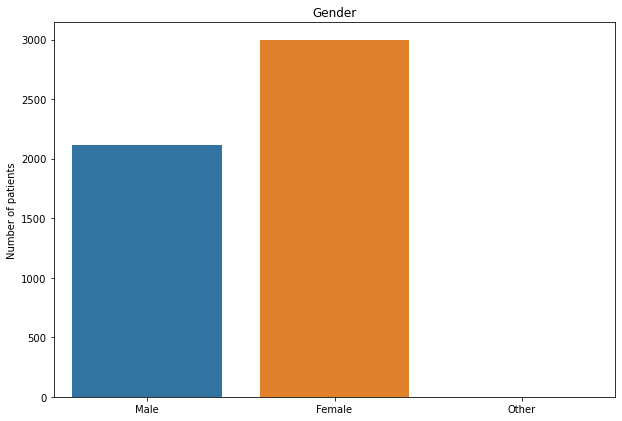

In [1179]:
fig = plt.figure()
axes = fig.add_axes([0,0,1.3,1.3])
sns.barplot(x=['Male','Female','Other'], y=[len(df[df.gender==0]),len(df[df.gender==1]),len(df[df.gender==2])])
plt.title('Gender')
plt.ylabel('Number of patients')

In [1180]:
print('Male:',len(df[df.gender==0]),'\nFemale:',len(df[df.gender==1]),'\nOther:',len(df[df.gender==2]))

Male: 2115 
Female: 2994 
Other: 1


Text(0, 0.5, 'Number of patients')

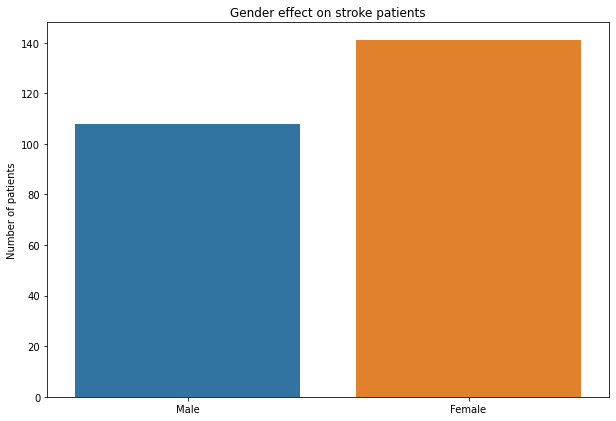

In [1181]:
fig = plt.figure()
axes = fig.add_axes([0,0,1.3,1.3])
male = df.groupby('stroke').get_group(1).groupby('gender').get_group(0).stroke.count()
female = df.groupby('stroke').get_group(1).groupby('gender').get_group(1).stroke.count()
# 'Other' had no diagnosed patients
sns.barplot(x=['Male','Female'], y=[male,female])
plt.title('Gender effect on stroke patients')
plt.ylabel('Number of patients')

In [1182]:
print('Male:',male, '\nFemale:',female)

Male: 108 
Female: 141


Seems that females tend to have a stroke more than males, But there are more females than males so that explains the difference

### Age

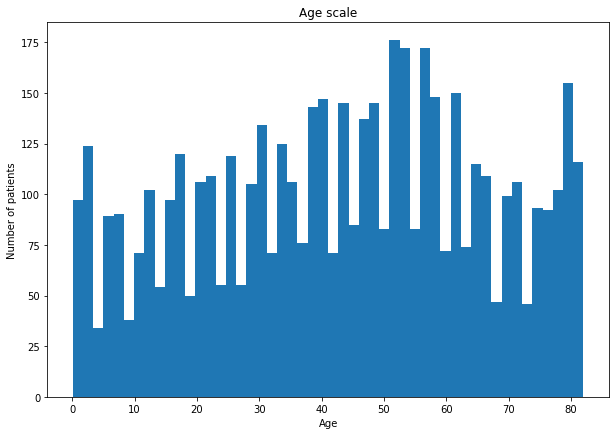

In [1183]:
fig = plt.figure()
axes = fig.add_axes([0,0,1.3,1.3])
plt.hist(df['age'],bins=50)
plt.title('Age scale')
plt.xlabel('Age')
plt.ylabel('Number of patients')
plt.xticks(np.arange(0,90,10))
plt.show()

The age scale is diverse, so this is a good scale to see the age's effects on stroke patients

In [1184]:
# count- counts rows in df, sum - sums value of each row in df

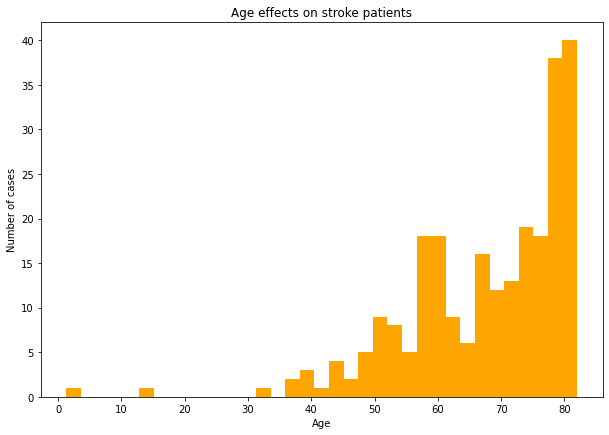

In [1185]:
fig = plt.figure()
axes = fig.add_axes([0,0,1.3,1.3])
plt.hist(df.groupby('stroke').get_group(1).age,bins=35, color='orange')
plt.title('Age effects on stroke patients')
plt.xlabel('Age')
plt.ylabel('Number of cases')
plt.show()

Diagnosed patients tends to have a stroke at an old age

### Hypertension

In [1186]:
strokeAndHypertension = df.groupby('stroke').get_group(1).groupby('hypertension').get_group(1).stroke.count()
strokeNoHypertension = df.groupby('stroke').get_group(1).groupby('hypertension').get_group(0).stroke.count()
noStrokeAndHypertension = df.groupby('stroke').get_group(0).groupby('hypertension').get_group(1).stroke.count()
noStrokeNoHypertenstion = df.groupby('stroke').get_group(0).groupby('hypertension').get_group(0).stroke.count()

Text(0.5, 1.0, 'Hypertension effects on stroke patients')

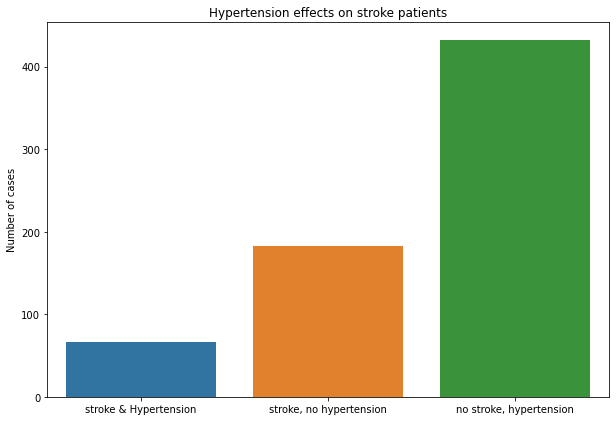

In [1187]:
fig = plt.figure()
axes = fig.add_axes([0,0,1.3,1.3])
sns.barplot(x=['stroke & Hypertension','stroke, no hypertension', 'no stroke, hypertension']
           ,y=[strokeAndHypertension, strokeNoHypertension, noStrokeAndHypertension])
plt.ylabel('Number of cases')
plt.title('Hypertension effects on stroke patients')

In [1188]:
print("stroke and hypertension:", strokeAndHypertension, "\nstroke, no hypertension:", strokeNoHypertension)
print("no stroke, has hypertension:", noStrokeAndHypertension, "\nno stroke no hypertension:", noStrokeNoHypertenstion)

stroke and hypertension: 66 
stroke, no hypertension: 183
no stroke, has hypertension: 432 
no stroke no hypertension: 4429


This is a bit strange, but it seems that there is no real connection between the two

### Heart disease

In [1189]:
strokeAndHeart = df.groupby('stroke').get_group(1).groupby('heart_disease').get_group(1).stroke.count()
strokeNoHeart = df.groupby('stroke').get_group(1).groupby('heart_disease').get_group(0).stroke.count()
noStrokeAndHeart = df.groupby('stroke').get_group(0).groupby('heart_disease').get_group(1).stroke.count()
noStrokeNoHeart = df.groupby('stroke').get_group(0).groupby('heart_disease').get_group(0).stroke.count()

Text(0.5, 1.0, 'Heart disease effects on stroke patients')

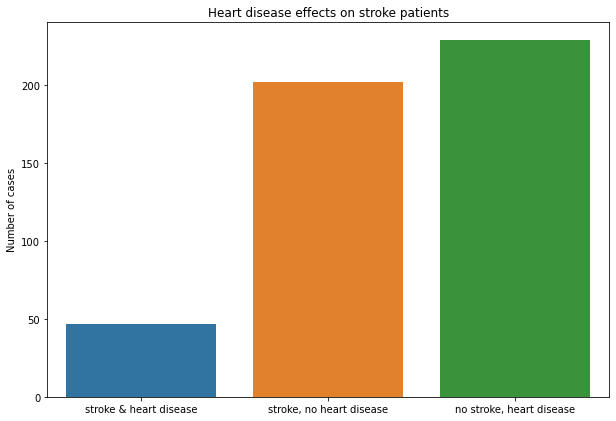

In [1190]:
fig = plt.figure()
axes = fig.add_axes([0,0,1.3,1.3])
sns.barplot(x=['stroke & heart disease','stroke, no heart disease', 'no stroke, heart disease']
           ,y=[strokeAndHeart, strokeNoHeart, noStrokeAndHeart])
plt.ylabel('Number of cases')
plt.title('Heart disease effects on stroke patients')

In [1191]:
print("stroke and heart disease:", strokeAndHeart, "\nstroke, no heart disease:", strokeNoHeart)
print("no stroke, has heart disease:", noStrokeAndHeart, "\nno stroke no heart disease:", noStrokeNoHeart)

stroke and heart disease: 47 
stroke, no heart disease: 202
no stroke, has heart disease: 229 
no stroke no heart disease: 4632


This is a bit strange, but it seems that there is no real connection between the two

### Average glucose level

In [1192]:
vertical=[]
horizontal=[]
for i in range(len(df)):
    horizontal.append(df['age'][i])
    vertical.append(df['avg_glucose_level'][i])

Text(0, 0.5, 'avg glucose level')

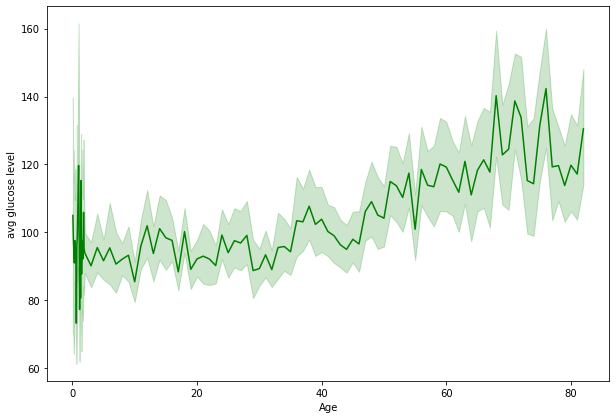

In [1193]:
fig = plt.figure()
axes = fig.add_axes([0,0,1.3,1.3])
sns.lineplot(x=horizontal, y=vertical, color='green')
plt.xlabel('Age')
plt.ylabel('avg glucose level')

The average glucose level in the patient's blood at an old age is higher  
This might indicate that higher average glucose level may affect the patient to have a stroke, like age does  
lets test that:

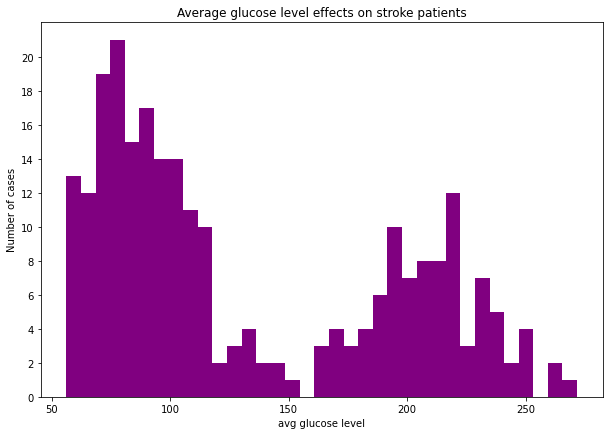

In [1194]:
fig = plt.figure()
axes = fig.add_axes([0,0,1.3,1.3])
plt.hist(df.groupby('stroke').get_group(1).avg_glucose_level.round(1),bins=35, color='purple')
# round(1) so the result wont be too scattered
plt.title('Average glucose level effects on stroke patients')
plt.xlabel('avg glucose level')
plt.ylabel('Number of cases')
plt.yticks(np.arange(0,21,2))
plt.show()

Seems that my little "theory" is false

### Ever married

In [1195]:
strokeMarried = df.groupby('stroke').get_group(1).groupby('ever_married').get_group(1).stroke.count()
strokeSingle = df.groupby('stroke').get_group(1).groupby('ever_married').get_group(0).stroke.count()
noStrokeMarried = df.groupby('stroke').get_group(0).groupby('ever_married').get_group(1).stroke.count()
noStrokeSingle = df.groupby('stroke').get_group(0).groupby('ever_married').get_group(0).stroke.count()

Text(0.5, 1.0, 'Marriage effects on stroke patients')

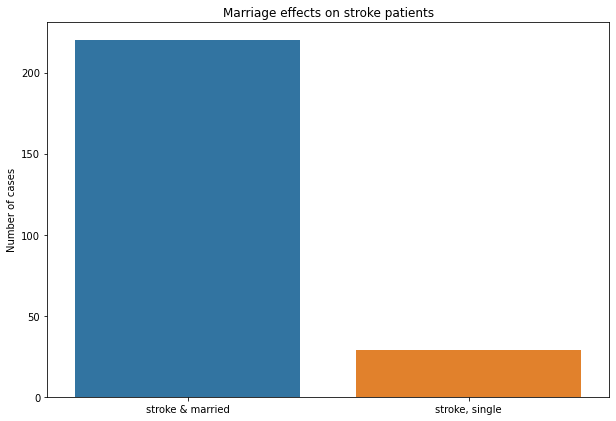

In [1196]:
fig = plt.figure()
axes = fig.add_axes([0,0,1.3,1.3])
sns.barplot(x=['stroke & married','stroke, single']
           ,y=[strokeMarried, strokeSingle])
plt.ylabel('Number of cases')
plt.title('Marriage effects on stroke patients')

In [1197]:
print("stroke and married:", strokeMarried, "\nstroke, single:", strokeSingle)
print("no stroke, married:", noStrokeMarried, "\nno stroke, single:", noStrokeSingle)

stroke and married: 220 
stroke, single: 29
no stroke, married: 3133 
no stroke, single: 1728


Makes sense overall, since most married people are not young, and age affects the possibility to have a stroke pretty badly

### Work type

Text(0, 0.5, 'Number of patients')

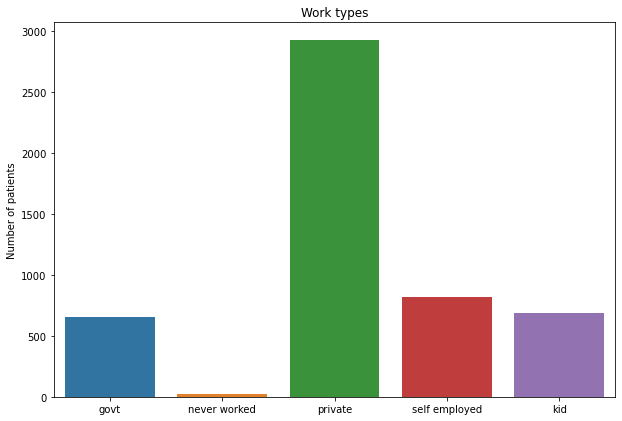

In [1198]:
fig = plt.figure()
axes = fig.add_axes([0,0,1.3,1.3])
sns.barplot(x=['govt','never worked','private','self employed', 'kid'], 
            y=[len(df[df.work_type==0]),len(df[df.work_type==1]),
               len(df[df.work_type==2]),len(df[df.work_type==3]),len(df[df.work_type==4])])
plt.title('Work types')
plt.ylabel('Number of patients')

In [1199]:
govt = df.groupby('stroke').get_group(1).groupby('work_type').get_group(0).stroke.count()
# 'never_worked' has no diagnosed patients
private = df.groupby('stroke').get_group(1).groupby('work_type').get_group(2).stroke.count()
self = df.groupby('stroke').get_group(1).groupby('work_type').get_group(3).stroke.count()
kid = df.groupby('stroke').get_group(1).groupby('work_type').get_group(4).stroke.count()

Text(0, 0.5, 'Number of cases')

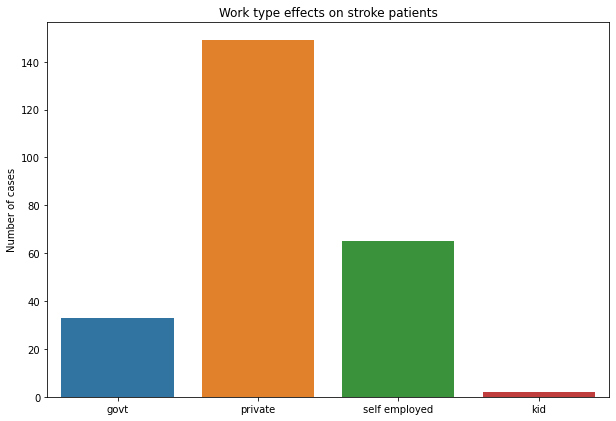

In [1200]:
fig = plt.figure()
axes = fig.add_axes([0,0,1.3,1.3])
sns.barplot(x=['govt','private','self employed', 'kid'], y=[govt,private,self,kid])
plt.title('Work type effects on stroke patients')
plt.ylabel('Number of cases')

In [1201]:
print("govt:", govt, "\nprivate:", private, "\nself employed:", self, "\nkid:", kid)

govt: 33 
private: 149 
self employed: 65 
kid: 2


Seems that the private sector tend to have a stroke more than any other sector, But there are MUCH more private sector employees than any other sector so that explains the difference

### Residence type

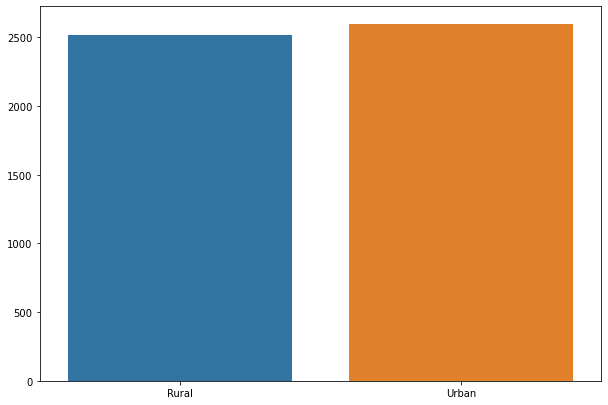

In [1202]:
fig = plt.figure()
axes = fig.add_axes([0,0,1.3,1.3])
sns.barplot(x=['Rural','Urban'], y=[len(df[df.Residence_type==0]),len(df[df.Residence_type==1])])

In [1203]:
rural=df.groupby('stroke').get_group(1).groupby('Residence_type').get_group(0).stroke.count()
urban=df.groupby('stroke').get_group(1).groupby('Residence_type').get_group(1).stroke.count()

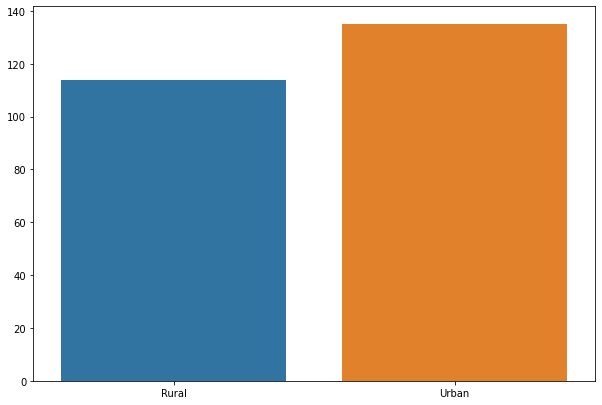

In [1204]:
fig = plt.figure()
axes = fig.add_axes([0,0,1.3,1.3])
sns.barplot(x=['Rural','Urban'], y=[rural,urban])

In [1205]:
print('Rural:',rural, '\nUrban:', urban)

Rural: 114 
Urban: 135


Seems that there are more diagnosed patients that live in urban places than those in rural places  
My guess is that the "Urban Life Style" causes stress that leads to a stroke

### BMI

In [1206]:
vertical=[]
horizontal=[]
for i in range(len(df)):
    horizontal.append(df['age'][i])
    vertical.append(df['bmi'][i])

Text(0, 0.5, 'bmi')

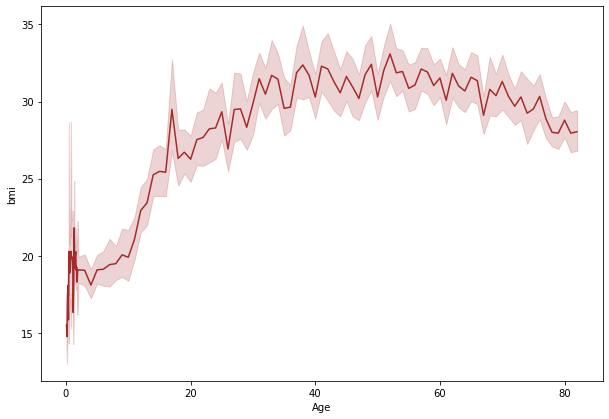

In [1207]:
fig = plt.figure()
axes = fig.add_axes([0,0,1.3,1.3])
sns.lineplot(x=horizontal, y=vertical, color='brown')
plt.xlabel('Age')
plt.ylabel('bmi')

The BMI of the patients at an old age is higher  
This might indicate that higher BMI may affect the patient to have a stroke, like age does  
lets test that:

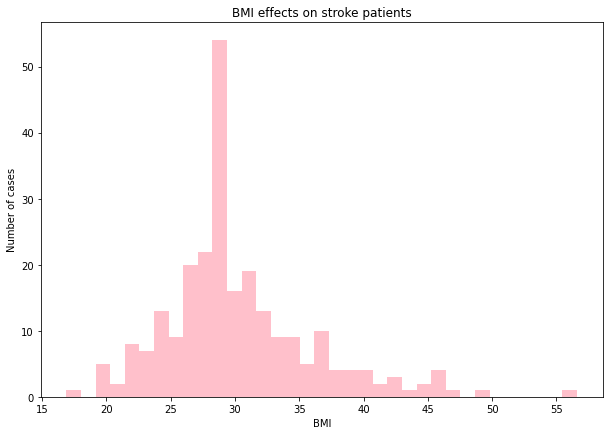

In [1208]:
fig = plt.figure()
axes = fig.add_axes([0,0,1.3,1.3])
plt.hist(df.groupby('stroke').get_group(1).bmi.round(1),bins=35, color='pink')
# round(1) so the result wont be too scattered
plt.title('BMI effects on stroke patients')
plt.xlabel('BMI')
plt.ylabel('Number of cases')
plt.show()

Most cases are between 25-30 BMI which are overweight patients, but not obese  
my little "theory" is true but not entirely since the number of cases decreases when BMI > 30

### Smoking status

Text(0, 0.5, 'Number of patients')

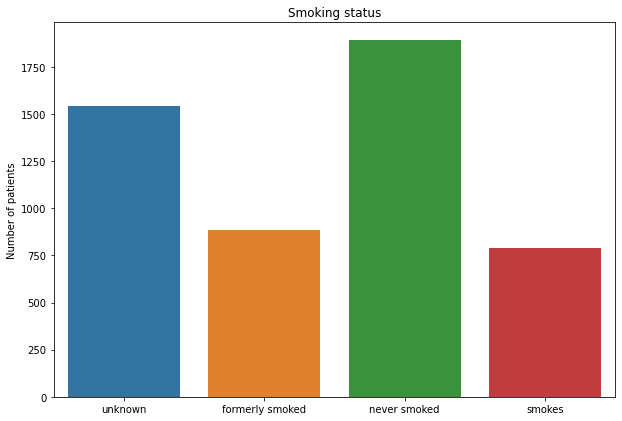

In [1209]:
fig = plt.figure()
axes = fig.add_axes([0,0,1.3,1.3])
sns.barplot(x=['unknown','formerly smoked','never smoked','smokes'], 
            y=[len(df[df.smoking_status==0]),len(df[df.smoking_status==1]),
               len(df[df.smoking_status==2]),len(df[df.smoking_status==3])])
plt.title('Smoking status')
plt.ylabel('Number of patients')

In [1210]:
# we cant conclude anything from 'unknown'
former = df.groupby('stroke').get_group(1).groupby('smoking_status').get_group(1).stroke.count()
self = df.groupby('stroke').get_group(1).groupby('smoking_status').get_group(2).stroke.count()
kid = df.groupby('stroke').get_group(1).groupby('smoking_status').get_group(3).stroke.count()

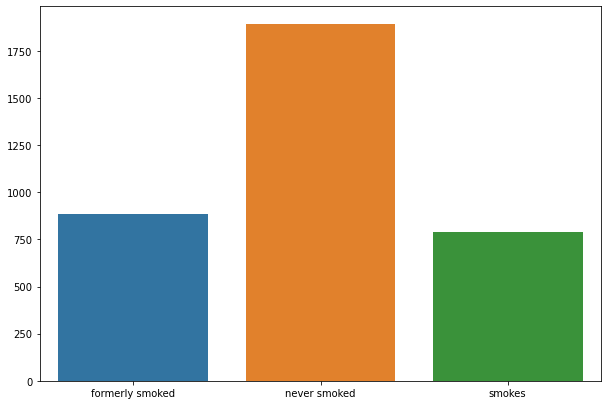

In [1211]:
fig = plt.figure()
axes = fig.add_axes([0,0,1.3,1.3])
sns.barplot(x=['formerly smoked','never smoked','smokes'], 
            y=[len(df[df.smoking_status==1]),len(df[df.smoking_status==2]),len(df[df.smoking_status==3])])

This is strage, since smoking is unhealthy in general

# Building the model

### Correlation heatmap

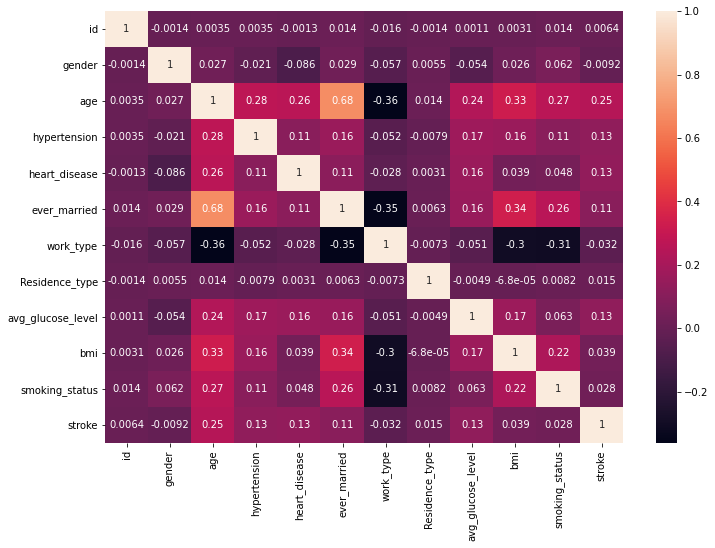

In [1212]:
fig = plt.figure()
axes = fig.add_axes([0,0,1.5,1.5])
sns.heatmap(df.corr(),annot=True)

There are no features that aren't correlated at all with 'stroke'  
Also, There are no features that are correlated much with 'stroke'
There is no point to drop features for our model (except ID which has no meaning)

In [1213]:
df=df.drop('id',axis=1)

### The setup

In [1214]:
X=df.drop('stroke',axis=1)
y=df.stroke

In [1215]:
print(X.shape)
print(y.shape)

(5110, 10)
(5110,)


Seems good

In [1216]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2, random_state=42)

### Classification method

In [1217]:
print('ratio is:',(sum(df.stroke==1)/sum(df.stroke==0))*100,'which is about 1/20')

ratio is: 5.122402797778235 which is about 1/20


So, I will use 2 methods. One is using threshold, second is oversampling. The best of the two will be chosen

In [1218]:
X_train_res, y_train_res = RandomOverSampler().fit_resample(X_train, y_train)

In [1219]:
print('Class 0 before oversampling:', sum(y_train==0),'\nClass 1 before oversampling:', sum(y_train==1))
print('Class 0 after oversampling:', sum(y_train_res==0),'\nClass 1 after oversampling:', sum(y_train_res==1))

Class 0 before oversampling: 3901 
Class 1 before oversampling: 187
Class 0 after oversampling: 3901 
Class 1 after oversampling: 3901


### Dummy Classifier

#### Threshold

In [1220]:
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train,y_train)
pred_dummy = dummy.predict(X_test)

In [1221]:
print(classification_report(y_test,pred_dummy))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97       960
           1       0.00      0.00      0.00        62

    accuracy                           0.94      1022
   macro avg       0.47      0.50      0.48      1022
weighted avg       0.88      0.94      0.91      1022



C:\Users\ofek8\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [1222]:
print(confusion_matrix(y_test,pred_dummy))

[[960   0]
 [ 62   0]]


#### Oversampling

In [1223]:
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train_res,y_train_res)
pred_dummy = dummy.predict(X_test)

In [1224]:
print(classification_report(y_test,pred_dummy))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97       960
           1       0.00      0.00      0.00        62

    accuracy                           0.94      1022
   macro avg       0.47      0.50      0.48      1022
weighted avg       0.88      0.94      0.91      1022



In [1225]:
print(confusion_matrix(y_test,pred_dummy))

[[960   0]
 [ 62   0]]


### KNN

#### Threshold

Text(0, 0.5, 'Testing Accuracy')

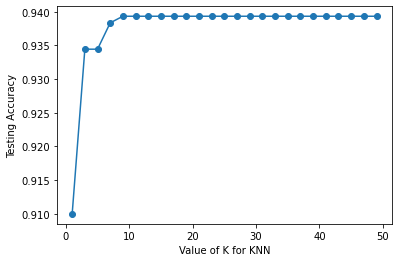

In [1226]:
k_range = list(range(1, 51, 2))
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train,y_train)
    pred = knn.predict(X_test)
    scores.append(metrics.accuracy_score(y_test, pred))
plt.plot(k_range, scores, marker='o')
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')

In [1227]:
knn = KNeighborsClassifier(n_neighbors=9)
knn.fit(X_train,y_train)
knn.predict_proba(X_test)[:,1].mean()

0.043596434007392916

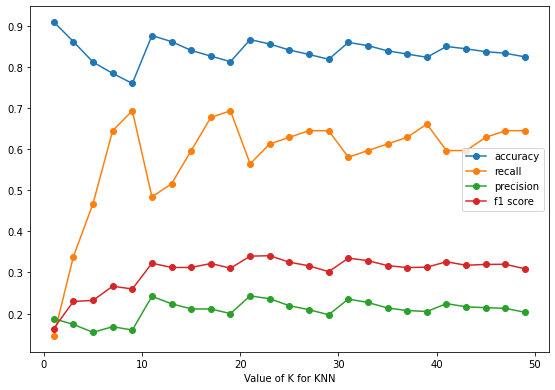

In [1228]:
k_range = list(range(1,51,2))
accuracy = []
recall = []
precision = []
f1 = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train,y_train)
    pred = (knn.predict_proba(X_test)[:,1]>0.1).astype(int)
    accuracy.append(metrics.accuracy_score(y_test, pred))
    recall.append(recall_score(y_test, pred))
    precision.append(precision_score(y_test, pred))
    f1.append(f1_score(y_test, pred))
    
fig = plt.figure()
axes = fig.add_axes([0,0,1.2,1.2])
plt.plot(k_range, accuracy, marker='o', label='accuracy')
plt.plot(k_range, recall, marker='o', label='recall')
plt.plot(k_range, precision, marker='o', label='precision')
plt.plot(k_range, f1, marker='o', label='f1 score')
plt.xlabel('Value of K for KNN')
plt.legend()

The optimal k is 19, since I want to get the highest result for all scores, with highest weight possible for recall

In [1229]:
knn = KNeighborsClassifier(n_neighbors=19)
knn.fit(X_train,y_train)
pred_knn = (knn.predict_proba(X_test)[:,1]>0.1).astype(int)

In [1230]:
print(classification_report(y_test,pred_knn))

              precision    recall  f1-score   support

           0       0.98      0.82      0.89       960
           1       0.20      0.69      0.31        62

    accuracy                           0.81      1022
   macro avg       0.59      0.76      0.60      1022
weighted avg       0.93      0.81      0.86      1022



In [1231]:
print(confusion_matrix(y_test,pred_knn))

[[788 172]
 [ 19  43]]


#### Oversampling

Text(0, 0.5, 'Testing Accuracy')

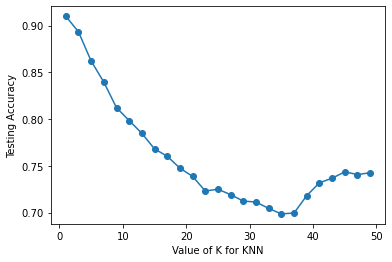

In [1232]:
k_range = list(range(1, 51, 2))
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_res,y_train_res)
    pred = knn.predict(X_test)
    scores.append(metrics.accuracy_score(y_test, pred))
plt.plot(k_range, scores, marker='o')
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')

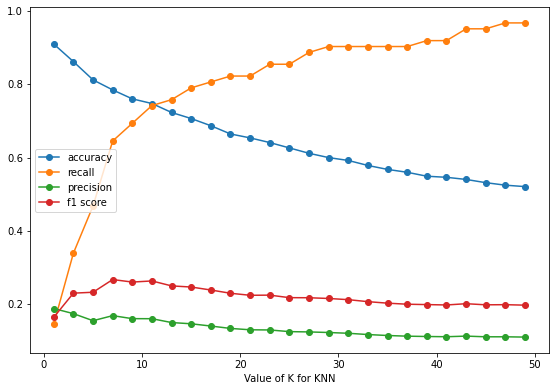

In [1233]:
k_range = list(range(1,51,2))
accuracy = []
recall = []
precision = []
f1 = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_res,y_train_res)
    pred = (knn.predict_proba(X_test)[:,1]>0.1).astype(int)
    accuracy.append(metrics.accuracy_score(y_test, pred))
    recall.append(recall_score(y_test, pred))
    precision.append(precision_score(y_test, pred))
    f1.append(f1_score(y_test, pred))
    
fig = plt.figure()
axes = fig.add_axes([0,0,1.2,1.2])
plt.plot(k_range, accuracy, marker='o', label='accuracy')
plt.plot(k_range, recall, marker='o', label='recall')
plt.plot(k_range, precision, marker='o', label='precision')
plt.plot(k_range, f1, marker='o', label='f1 score')
plt.xlabel('Value of K for KNN')
plt.legend()

The optimal k is 11, since I want to get the highest result for all scores, with highest weight possible for recall

In [1234]:
knn = KNeighborsClassifier(n_neighbors=11)
knn.fit(X_train_res,y_train_res)
pred_knn = knn.predict(X_test)

In [1235]:
print(classification_report(y_test,pred_knn))

              precision    recall  f1-score   support

           0       0.97      0.81      0.88       960
           1       0.18      0.63      0.27        62

    accuracy                           0.80      1022
   macro avg       0.57      0.72      0.58      1022
weighted avg       0.92      0.80      0.85      1022



In [1236]:
print(confusion_matrix(y_test,pred_knn))

[[777 183]
 [ 23  39]]


Threshold method provides better results, so threshold will be the chosen one:

In [1237]:
knn = KNeighborsClassifier(n_neighbors=19)
knn.fit(X_train,y_train)
pred_knn = (knn.predict_proba(X_test)[:,1]>0.1).astype(int)

### Logistic Regression

#### Threshold

In [1238]:
logreg = LogisticRegression(solver='liblinear')
logreg.fit(X_train, y_train)
logreg.predict_proba(X_test)[:,1].mean()

0.046515563788522715

In [1239]:
logreg = LogisticRegression(solver='lbfgs', max_iter=1000)
logreg.fit(X_train, y_train)
logreg.predict_proba(X_test)[:,1].mean()

0.0446228008190485

In [1240]:
logreg = LogisticRegression(solver='liblinear')
logreg.fit(X_train, y_train)
pred_log1 = (logreg.predict_proba(X_test)[:,1]>0.1).astype(int)

In [1241]:
print(classification_report(y_test, pred_log1))

              precision    recall  f1-score   support

           0       0.97      0.88      0.92       960
           1       0.23      0.55      0.33        62

    accuracy                           0.86      1022
   macro avg       0.60      0.72      0.63      1022
weighted avg       0.92      0.86      0.89      1022



In [1242]:
print(confusion_matrix(y_test, pred_log1))

[[848 112]
 [ 28  34]]


In [1243]:
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)
pred_log2 = (logreg.predict_proba(X_test)[:,1]>0.1).astype(int)

In [1244]:
print(classification_report(y_test, pred_log2))

              precision    recall  f1-score   support

           0       0.97      0.88      0.92       960
           1       0.24      0.56      0.33        62

    accuracy                           0.86      1022
   macro avg       0.60      0.72      0.63      1022
weighted avg       0.92      0.86      0.89      1022



In [1245]:
print(confusion_matrix(y_test, pred_log2))

[[847 113]
 [ 27  35]]


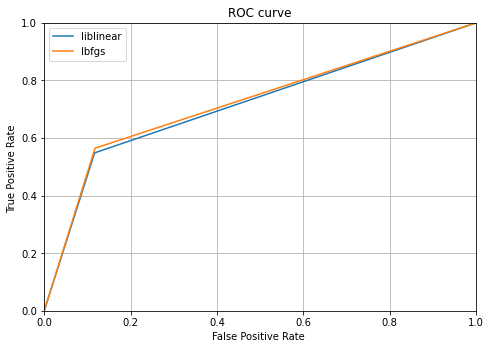

In [1246]:
fig = plt.figure()
axes = fig.add_axes([0,0,1,1])
fpr, tpr, thresholds = roc_curve(y_test, pred_log1)
plt.plot(fpr, tpr, label='liblinear')
fpr, tpr, thresholds = roc_curve(y_test, pred_log2)
plt.plot(fpr, tpr, label='lbfgs')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve')
plt.xlabel('False Positive Rate ')
plt.ylabel('True Positive Rate ')
plt.legend()
plt.grid()

In [1247]:
print('liblinear\'s AUC:',roc_auc_score(y_test,pred_log1),'\nlbfgs\'s AUC:',roc_auc_score(y_test,pred_log2))

liblinear's AUC: 0.7158602150537634 
lbfgs's AUC: 0.7234038978494624


#### Oversampling

In [1248]:
logreg = LogisticRegression(solver='liblinear')
logreg.fit(X_train_res, y_train_res)
pred_log1 = logreg.predict(X_test)

In [1249]:
print(classification_report(y_test, pred_log1))

              precision    recall  f1-score   support

           0       0.98      0.75      0.85       960
           1       0.16      0.76      0.27        62

    accuracy                           0.75      1022
   macro avg       0.57      0.75      0.56      1022
weighted avg       0.93      0.75      0.81      1022



In [1250]:
print(confusion_matrix(y_test, pred_log1))

[[719 241]
 [ 15  47]]


In [1251]:
logreg = LogisticRegression(solver='lbfgs',max_iter=1000)
logreg.fit(X_train_res, y_train_res)
pred_log2 = logreg.predict(X_test)

In [1252]:
print(classification_report(y_test, pred_log2))

              precision    recall  f1-score   support

           0       0.98      0.75      0.85       960
           1       0.17      0.76      0.27        62

    accuracy                           0.75      1022
   macro avg       0.57      0.76      0.56      1022
weighted avg       0.93      0.75      0.82      1022



In [1253]:
print(confusion_matrix(y_test, pred_log2))

[[723 237]
 [ 15  47]]


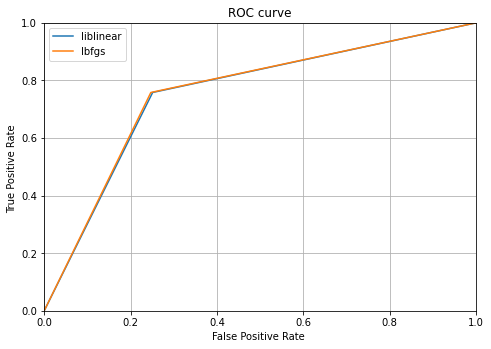

In [1254]:
fig = plt.figure()
axes = fig.add_axes([0,0,1,1])
fpr, tpr, thresholds = roc_curve(y_test, pred_log1)
plt.plot(fpr, tpr, label='liblinear')
fpr, tpr, thresholds = roc_curve(y_test, pred_log2)
plt.plot(fpr, tpr, label='lbfgs')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve')
plt.xlabel('False Positive Rate ')
plt.ylabel('True Positive Rate ')
plt.legend()
plt.grid()

In [1255]:
print('liblinear\'s AUC:',roc_auc_score(y_test,pred_log1),'\nlbfgs\'s AUC:',roc_auc_score(y_test,pred_log2))

liblinear's AUC: 0.7535114247311829 
lbfgs's AUC: 0.7555947580645163


Oversampling method provides better results, so oversampling will be the chosen one:

In [1256]:
logreg = LogisticRegression(solver='lbfgs',max_iter=1000)
logreg.fit(X_train_res, y_train_res)
pred_log = logreg.predict(X_test)

### Decision Tree

#### Threshold

In [1257]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)
pred_dtc = dtc.predict(X_test)

In [1258]:
print(classification_report(y_test, pred_dtc))

              precision    recall  f1-score   support

           0       0.95      0.96      0.95       960
           1       0.20      0.15      0.17        62

    accuracy                           0.91      1022
   macro avg       0.57      0.55      0.56      1022
weighted avg       0.90      0.91      0.91      1022



In [1259]:
print(confusion_matrix(y_test, pred_dtc))

[[924  36]
 [ 53   9]]


In [1260]:
dtc.predict_proba(X_test)[:,1].mean()

0.04403131115459882

In [1261]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)
pred_dtc = (dtc.predict_proba(X_test)[:,1]>0.1).astype(int)

In [1262]:
print(classification_report(y_test, pred_dtc))

              precision    recall  f1-score   support

           0       0.95      0.96      0.95       960
           1       0.19      0.15      0.17        62

    accuracy                           0.91      1022
   macro avg       0.57      0.55      0.56      1022
weighted avg       0.90      0.91      0.91      1022



In [1263]:
print(confusion_matrix(y_test, pred_dtc))

[[922  38]
 [ 53   9]]


Apperantly, Decision Tree Classifier doesnt need a threshold.

#### Oversampling

In [1264]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train_res, y_train_res)
pred_dtc = dtc.predict(X_test)

In [1265]:
print(classification_report(y_test, pred_dtc))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95       960
           1       0.13      0.10      0.11        62

    accuracy                           0.91      1022
   macro avg       0.54      0.53      0.53      1022
weighted avg       0.89      0.91      0.90      1022



In [1266]:
print(confusion_matrix(y_test, pred_dtc))

[[921  39]
 [ 56   6]]


Both methods provide approximately the same results. Without loss of generality, the default dtc will be chosen:

In [1267]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)
pred_dtc = dtc.predict(X_test)

# Summary

Using ROC evaluation, I'll distinguish which model is the best for my goal

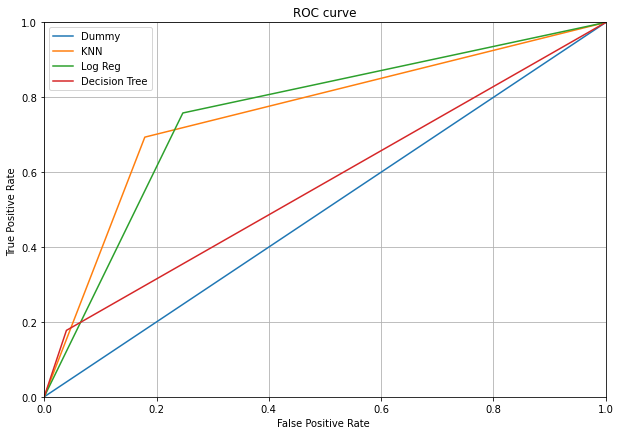

In [1268]:
fig = plt.figure()
axes = fig.add_axes([0,0,1.3,1.3])

fpr, tpr, thresholds = roc_curve(y_test, pred_dummy)
plt.plot(fpr, tpr, label='Dummy')
fpr, tpr, thresholds = roc_curve(y_test, pred_knn)
plt.plot(fpr, tpr, label='KNN')
fpr, tpr, thresholds = roc_curve(y_test, pred_log)
plt.plot(fpr, tpr, label='Log Reg')
fpr, tpr, thresholds = roc_curve(y_test, pred_dtc)
plt.plot(fpr, tpr, label='Decision Tree')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve')
plt.xlabel('False Positive Rate ')
plt.ylabel('True Positive Rate ')
plt.grid()
plt.legend()

In [1269]:
print('Dummy\'s AUC:',roc_auc_score(y_test,pred_dummy),'\nKNN\'s AUC:',roc_auc_score(y_test,pred_knn))
print('Log Reg\'s AUC:', roc_auc_score(y_test,pred_log2), '\nDecision Tree\'s AUC:',roc_auc_score(y_test,pred_dtc))

Dummy's AUC: 0.5 
KNN's AUC: 0.7571908602150538
Log Reg's AUC: 0.7555947580645163 
Decision Tree's AUC: 0.5689180107526882


To sum up, KNN seems to be the the best model for my goal